# TrainingMultiLabel
Entrainement des modèles de transfer learning DenseNet201 13 bandes pour café contre reste et culture contre non-culture

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report, multilabel_confusion_matrix

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 
from IAdeforestation.evaluation import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9087668226123508445
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7356176160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16673798753436947830
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'multi_label')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

# Load base model

In [4]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [5]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(2, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Train  model

In [6]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_multilabel_coffee_2'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Fold 1 Number culture - train : 521
Fold 1 Number no-culture - train : 427
Fold 1 Number coffee - train : 948
Fold 1 Number other - train : 0
Fold 1 Number culture - val : 144
Fold 1 Number no-culture - val : 284
Fold 1 Number coffee - train : 428
Fold 1 Number other - train : 0
Training for fold 1
-----
Epoch 1/100
42/42 [==============================] - 16s 190ms/step - loss: 1.1039 - accuracy: 0.4486 - precision: 0.1500 - recall: 0.3024 - f1_score_keras: 0.2009 - val_loss: 0.9427 - val_accuracy: 0.6445 - val_precision: 0.3864 - val_recall: 0.2099 - val_f1_score_keras: 0.2698
Epoch 2/100
42/42 [==============================] - 6s 135ms/step - loss: 0.9379 - accuracy: 0.6369 - precision: 0.2960 - recall: 0.5119 - f1_score_keras: 0.3715 - val_loss: 0.8637 - val_accuracy: 0.7539 - val_precision: 0.7011 - val_recall: 0.4710 - val_f1_score_keras: 0.5652
Epoch 3/100
42/42 [==============================] - 6s 140ms/step - loss: 0.8432 - accuracy: 0.7434 - precision: 0.4604 - recall: 0.65

42/42 [==============================] - 6s 144ms/step - loss: 0.2928 - accuracy: 0.9387 - precision: 0.9084 - recall: 0.8211 - f1_score_keras: 0.8610 - val_loss: 0.4644 - val_accuracy: 0.8255 - val_precision: 0.9618 - val_recall: 0.4941 - val_f1_score_keras: 0.6530
Epoch 59/100
42/42 [==============================] - 6s 141ms/step - loss: 0.2983 - accuracy: 0.9401 - precision: 0.9180 - recall: 0.8078 - f1_score_keras: 0.8580 - val_loss: 0.4648 - val_accuracy: 0.8151 - val_precision: 0.9440 - val_recall: 0.4664 - val_f1_score_keras: 0.6226
Epoch 60/100
42/42 [==============================] - 6s 141ms/step - loss: 0.2750 - accuracy: 0.9467 - precision: 0.9130 - recall: 0.8352 - f1_score_keras: 0.8693 - val_loss: 0.4635 - val_accuracy: 0.8177 - val_precision: 0.9531 - val_recall: 0.4766 - val_f1_score_keras: 0.6350
Epoch 61/100
42/42 [==============================] - 6s 141ms/step - loss: 0.2714 - accuracy: 0.9527 - precision: 0.9266 - recall: 0.8556 - f1_score_keras: 0.8886 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rom

Fold 2 Number culture - train : 571
Fold 2 Number no-culture - train : 618
Fold 2 Number coffee - train : 1189
Fold 2 Number other - train : 0
Fold 2 Number culture - val : 94
Fold 2 Number no-culture - val : 93
Fold 2 Number coffee - train : 187
Fold 2 Number other - train : 0
Training for fold 2
-----
Epoch 1/100
54/54 [==============================] - 15s 167ms/step - loss: 1.0719 - accuracy: 0.5022 - precision: 0.3013 - recall: 0.6202 - f1_score_keras: 0.3618 - val_loss: 0.9220 - val_accuracy: 0.7695 - val_precision: 0.5410 - val_recall: 0.9565 - val_f1_score_keras: 0.6906
Epoch 2/100
54/54 [==============================] - 7s 130ms/step - loss: 0.9064 - accuracy: 0.6403 - precision: 0.4071 - recall: 0.7624 - f1_score_keras: 0.5300 - val_loss: 0.8454 - val_accuracy: 0.7344 - val_precision: 0.4560 - val_recall: 1.0000 - val_f1_score_keras: 0.6264
Epoch 3/100
54/54 [==============================] - 7s 126ms/step - loss: 0.8095 - accuracy: 0.7594 - precision: 0.5276 - recall: 0.831

54/54 [==============================] - 7s 126ms/step - loss: 0.2818 - accuracy: 0.9402 - precision: 0.9001 - recall: 0.8684 - f1_score_keras: 0.8825 - val_loss: 0.3136 - val_accuracy: 0.9062 - val_precision: 0.7879 - val_recall: 0.8387 - val_f1_score_keras: 0.8125
Epoch 59/100
54/54 [==============================] - 7s 126ms/step - loss: 0.2749 - accuracy: 0.9445 - precision: 0.9074 - recall: 0.8779 - f1_score_keras: 0.8906 - val_loss: 0.3491 - val_accuracy: 0.8867 - val_precision: 0.7500 - val_recall: 0.8095 - val_f1_score_keras: 0.7786
Epoch 60/100
54/54 [==============================] - 7s 128ms/step - loss: 0.2792 - accuracy: 0.9405 - precision: 0.9001 - recall: 0.8704 - f1_score_keras: 0.8835 - val_loss: 0.2981 - val_accuracy: 0.9102 - val_precision: 0.7941 - val_recall: 0.8571 - val_f1_score_keras: 0.8251
Epoch 61/100
54/54 [==============================] - 7s 126ms/step - loss: 0.2753 - accuracy: 0.9384 - precision: 0.8778 - recall: 0.8798 - f1_score_keras: 0.8776 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rom

Fold 3 Number culture - train : 549
Fold 3 Number no-culture - train : 479
Fold 3 Number coffee - train : 1028
Fold 3 Number other - train : 0
Fold 3 Number culture - val : 116
Fold 3 Number no-culture - val : 232
Fold 3 Number coffee - train : 348
Fold 3 Number other - train : 0
Training for fold 3
-----
Epoch 1/100
48/48 [==============================] - 15s 182ms/step - loss: 0.9822 - accuracy: 0.6492 - precision: 0.3229 - recall: 0.4673 - f1_score_keras: 0.2725 - val_loss: 0.8660 - val_accuracy: 0.7984 - val_precision: 0.7736 - val_recall: 0.5694 - val_f1_score_keras: 0.6523
Epoch 2/100
48/48 [==============================] - 6s 133ms/step - loss: 0.8813 - accuracy: 0.7212 - precision: 0.4157 - recall: 0.4586 - f1_score_keras: 0.4333 - val_loss: 0.7579 - val_accuracy: 0.9172 - val_precision: 0.8802 - val_recall: 0.8492 - val_f1_score_keras: 0.8648
Epoch 3/100
48/48 [==============================] - 6s 135ms/step - loss: 0.7986 - accuracy: 0.8025 - precision: 0.5861 - recall: 0.5

48/48 [==============================] - 6s 134ms/step - loss: 0.2772 - accuracy: 0.9433 - precision: 0.8624 - recall: 0.8911 - f1_score_keras: 0.8722 - val_loss: 0.4124 - val_accuracy: 0.8516 - val_precision: 0.7118 - val_recall: 0.9447 - val_f1_score_keras: 0.8113
Epoch 59/100
48/48 [==============================] - 6s 136ms/step - loss: 0.2738 - accuracy: 0.9463 - precision: 0.8828 - recall: 0.8903 - f1_score_keras: 0.8833 - val_loss: 0.4409 - val_accuracy: 0.8375 - val_precision: 0.6758 - val_recall: 0.9565 - val_f1_score_keras: 0.7913
Epoch 60/100
48/48 [==============================] - 6s 133ms/step - loss: 0.2800 - accuracy: 0.9403 - precision: 0.8758 - recall: 0.8720 - f1_score_keras: 0.8720 - val_loss: 0.4730 - val_accuracy: 0.8359 - val_precision: 0.6757 - val_recall: 0.9569 - val_f1_score_keras: 0.7919
Epoch 61/100
48/48 [==============================] - 6s 134ms/step - loss: 0.2519 - accuracy: 0.9566 - precision: 0.9105 - recall: 0.9054 - f1_score_keras: 0.9063 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rom

Fold 4 Number culture - train : 567
Fold 4 Number no-culture - train : 671
Fold 4 Number coffee - train : 1238
Fold 4 Number other - train : 0
Fold 4 Number culture - val : 98
Fold 4 Number no-culture - val : 40
Fold 4 Number coffee - train : 138
Fold 4 Number other - train : 0
Training for fold 4
-----
Epoch 1/100
57/57 [==============================] - 15s 160ms/step - loss: 0.9728 - accuracy: 0.6293 - precision: 0.3952 - recall: 0.5646 - f1_score_keras: 0.3750 - val_loss: 0.8451 - val_accuracy: 0.6875 - val_precision: 0.3190 - val_recall: 0.9737 - val_f1_score_keras: 0.4783
Epoch 2/100
57/57 [==============================] - 7s 126ms/step - loss: 0.8407 - accuracy: 0.7368 - precision: 0.5128 - recall: 0.6861 - f1_score_keras: 0.5857 - val_loss: 0.7484 - val_accuracy: 0.6992 - val_precision: 0.3529 - val_recall: 1.0000 - val_f1_score_keras: 0.5206
Epoch 3/100
57/57 [==============================] - 7s 123ms/step - loss: 0.7492 - accuracy: 0.8022 - precision: 0.6143 - recall: 0.802

57/57 [==============================] - 7s 126ms/step - loss: 0.2633 - accuracy: 0.9400 - precision: 0.8860 - recall: 0.8907 - f1_score_keras: 0.8870 - val_loss: 0.2707 - val_accuracy: 0.9297 - val_precision: 0.8387 - val_recall: 0.6667 - val_f1_score_keras: 0.7387
Epoch 59/100
57/57 [==============================] - 7s 122ms/step - loss: 0.2635 - accuracy: 0.9372 - precision: 0.8734 - recall: 0.8965 - f1_score_keras: 0.8845 - val_loss: 0.2745 - val_accuracy: 0.9297 - val_precision: 0.8000 - val_recall: 0.6061 - val_f1_score_keras: 0.6881
Epoch 60/100
57/57 [==============================] - 7s 124ms/step - loss: 0.2703 - accuracy: 0.9322 - precision: 0.8793 - recall: 0.8604 - f1_score_keras: 0.8679 - val_loss: 0.2947 - val_accuracy: 0.9258 - val_precision: 0.8571 - val_recall: 0.6154 - val_f1_score_keras: 0.7115
Epoch 61/100
57/57 [==============================] - 7s 123ms/step - loss: 0.2648 - accuracy: 0.9341 - precision: 0.8827 - recall: 0.8762 - f1_score_keras: 0.8788 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rom

Fold 5 Number culture - train : 452
Fold 5 Number no-culture - train : 649
Fold 5 Number coffee - train : 1101
Fold 5 Number other - train : 0
Fold 5 Number culture - val : 213
Fold 5 Number no-culture - val : 62
Fold 5 Number coffee - train : 275
Fold 5 Number other - train : 0
Training for fold 5
-----
Epoch 1/100
51/51 [==============================] - 15s 172ms/step - loss: 1.0306 - accuracy: 0.5992 - precision: 0.3340 - recall: 0.4835 - f1_score_keras: 0.3606 - val_loss: 0.8857 - val_accuracy: 0.6914 - val_precision: 0.2624 - val_recall: 0.8548 - val_f1_score_keras: 0.4016
Epoch 2/100
51/51 [==============================] - 7s 131ms/step - loss: 0.8821 - accuracy: 0.6929 - precision: 0.4818 - recall: 0.5785 - f1_score_keras: 0.5230 - val_loss: 0.7760 - val_accuracy: 0.7656 - val_precision: 0.3230 - val_recall: 0.8254 - val_f1_score_keras: 0.4650
Epoch 3/100
51/51 [==============================] - 6s 128ms/step - loss: 0.7850 - accuracy: 0.7742 - precision: 0.5907 - recall: 0.66

51/51 [==============================] - 6s 124ms/step - loss: 0.2851 - accuracy: 0.9393 - precision: 0.8919 - recall: 0.9024 - f1_score_keras: 0.8959 - val_loss: 0.2787 - val_accuracy: 0.9434 - val_precision: 0.6984 - val_recall: 0.8148 - val_f1_score_keras: 0.7521
Epoch 59/100
51/51 [==============================] - 6s 124ms/step - loss: 0.2905 - accuracy: 0.9343 - precision: 0.8789 - recall: 0.8971 - f1_score_keras: 0.8866 - val_loss: 0.2651 - val_accuracy: 0.9414 - val_precision: 0.6892 - val_recall: 0.8793 - val_f1_score_keras: 0.7695
Epoch 60/100
51/51 [==============================] - 6s 127ms/step - loss: 0.2782 - accuracy: 0.9406 - precision: 0.8883 - recall: 0.9046 - f1_score_keras: 0.8949 - val_loss: 0.2734 - val_accuracy: 0.9375 - val_precision: 0.6709 - val_recall: 0.8983 - val_f1_score_keras: 0.7661
Epoch 61/100
51/51 [==============================] - 6s 126ms/step - loss: 0.2801 - accuracy: 0.9378 - precision: 0.9125 - recall: 0.8767 - f1_score_keras: 0.8926 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rom

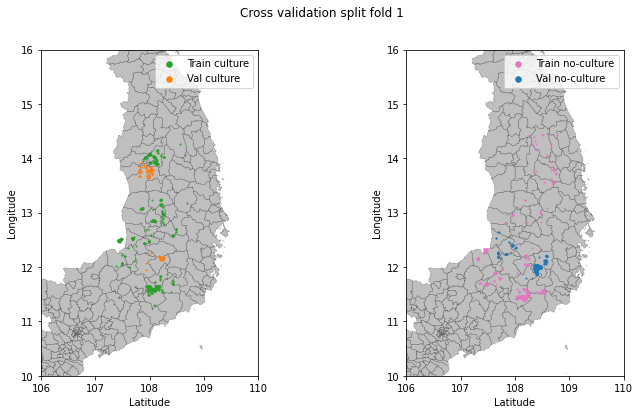

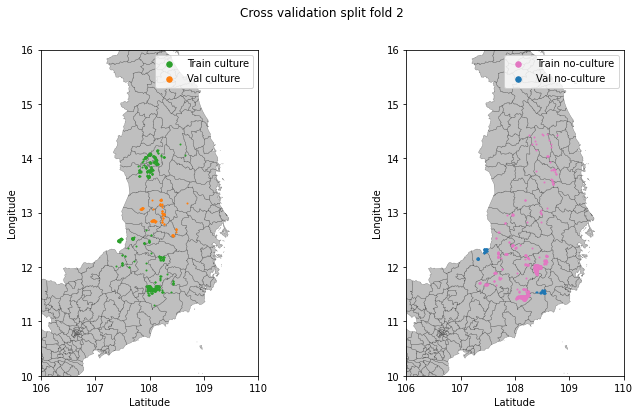

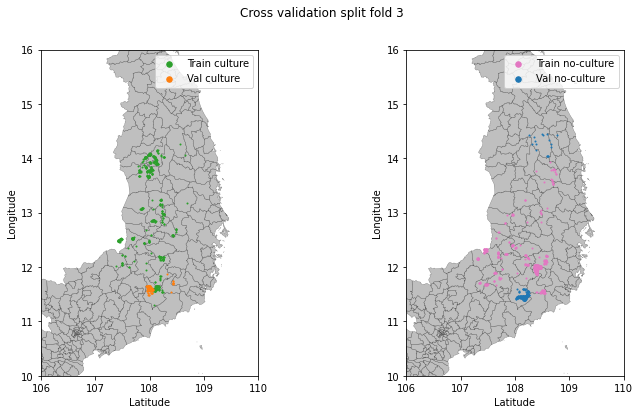

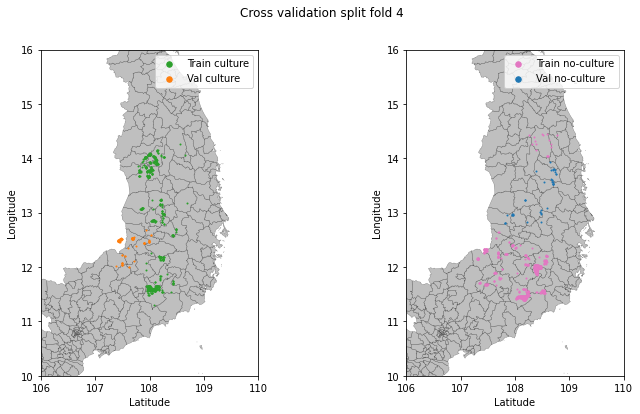

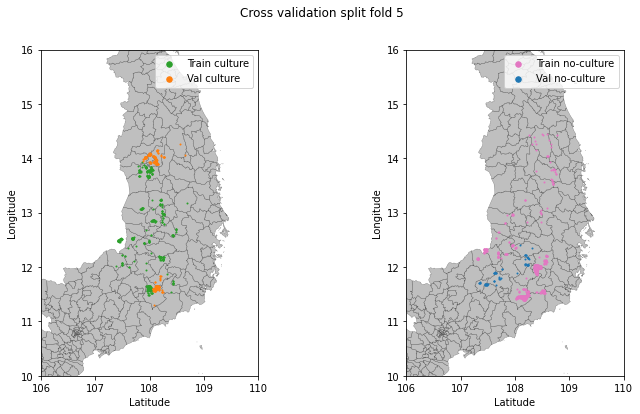

In [8]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_coffee_10fold1",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    geo_train['label_coffee']=0
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_coffee_10fold1",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)
    geo_val['label_coffee']=0

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold {i_fold+1}", column_name="label_culture", legend1=['Train culture', 'Val culture'], legend2=['Train no-culture', 'Val no-culture'])
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label_culture'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label_culture'] == 1])}")
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label_coffee'] == 0])}")
    print(f"Fold {i_fold+1} Number other - train : {len(geo_train[geo_train['label_coffee'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label_culture'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label_culture'] == 1])}")
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_val[geo_val['label_coffee'] == 0])}")
    print(f"Fold {i_fold+1} Number other - train : {len(geo_val[geo_val['label_coffee'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train[['label_culture','label_coffee']].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val[['label_culture','label_coffee']].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)

    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE),
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    validation_generator = generator(geo_val['path'].to_numpy(), 
                        geo_val[['label_culture','label_coffee']].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(geo_val))
    
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(validation_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

        Y_true = np.asarray(Y_true)
        Y_pred = np.asarray(Y_pred)

    cm = multilabel_confusion_matrix(Y_true, Y_pred)
    print(cm)
    print(classification_report(Y_true, Y_pred))

    print("\n")

    K.clear_session()

In [9]:
with open(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [10]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.890625
Stdev accuracy : 0.04414235339536453


Mean loss : 0.34249011874198915
Stdev loss : 0.09220725260545923


Mean precision : 0.7829020261764527
Stdev precision : 0.10317833989814215


Mean recall : 0.7680874586105346
Stdev recall : 0.15937225401218175


Mean F1-Score : 0.7535953998565674
Stdev F1-Score : 0.059701699712007575


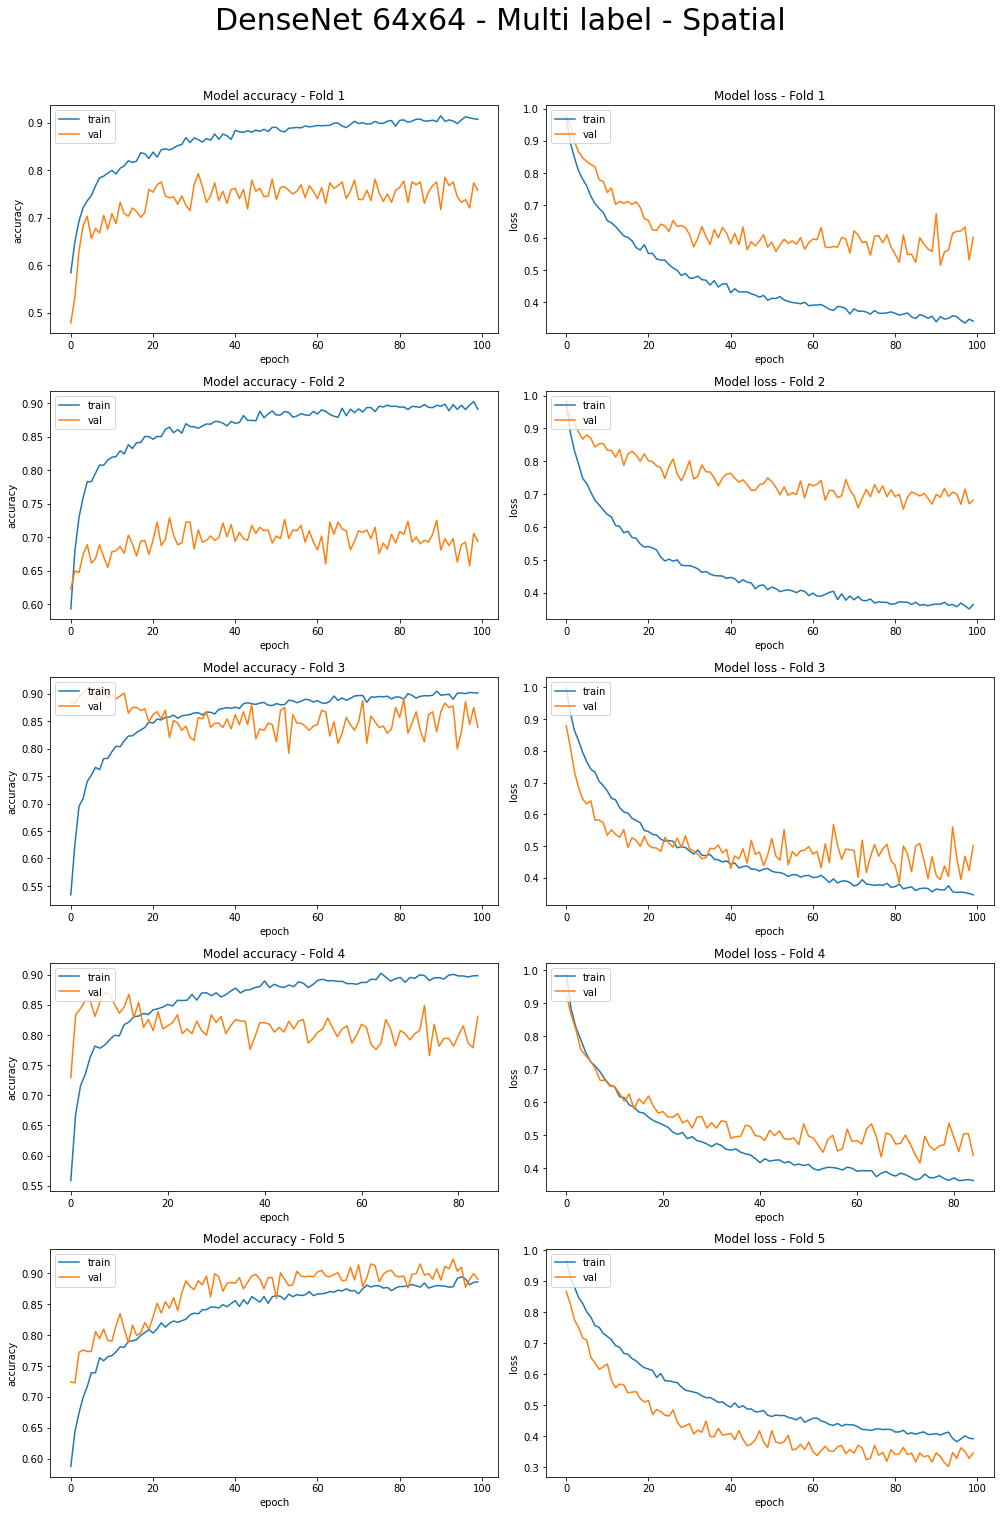

In [4]:
path = os.path.join(SAVED_MODELS_PATH, 'multi_label', 'final_spacv_10FOLD_multilabel_3')
plot_acc_loss(path, "DenseNet 64x64 - Multi label - Spatial")